In [ ]:
# @title ###### Licensed to the Apache Software Foundation (ASF), Version 2.0 (the "License")

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements. See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership. The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied. See the License for the
# specific language governing permissions and limitations
# under the License

# Remote inference in Apache Beam

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/apache/beam/blob/master/examples/notebooks/beam-ml/custom_remote_inference.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/main/tools/colab_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/apache/beam/blob/master/examples/notebooks/beam-ml/custom_remote_inference.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/main/tools/github_32px.png" />View source on GitHub</a>
  </td>
</table>


This example demonstrates how to implement a custom inference call in Apache Beam using the Google Cloud Vision API.

The prefered way to run inference in Apache Beam is by using the [RunInference API](https://beam.apache.org/documentation/sdks/python-machine-learning/). 
The RunInference API enables you to run models as part of your pipeline in a way that is optimized for machine learning inference. 
To reduce the number of steps that you need to take, RunInference supports features like batching. For more infomation about the RunInference API, review the [RunInference API](https://beam.apache.org/releases/pydoc/current/apache_beam.ml.inference.html#apache_beam.ml.inference.RunInference), 
which demonstrates how to implement model inference in PyTorch, scikit-learn, and TensorFlow.

Currently, the RunInference API doesn't support making remote inference calls using the Natural Language API, Cloud Vision API, and so on. 
Therefore, to use these remote APIs with Apache Beam, you need to write custom inference calls.

**Note:** all images are licensed CC-BY, creators are listed in the [LICENSE.txt](https://storage.googleapis.com/apache-beam-samples/image_captioning/LICENSE.txt) file.

## Run the Cloud Vision API

You can use the Cloud Vision API to retrieve labels that describe an image.
For example, the following image shows a lion with possible labels.

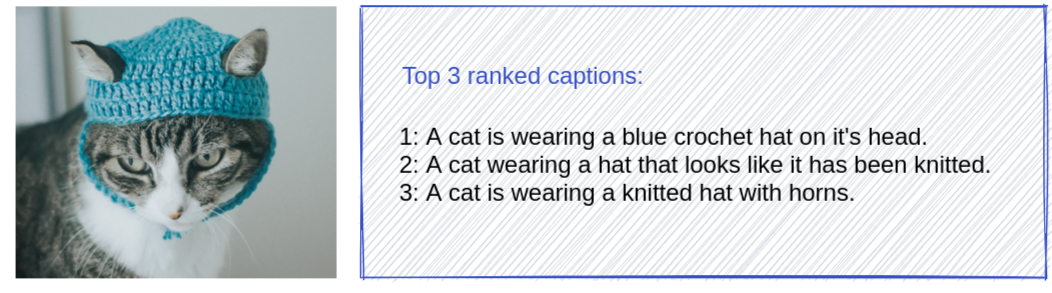

We want to run the Google Cloud Vision API on a large set of images, and Apache Beam is the ideal tool to handle this workflow.
This example demonstates how to retrieve image labels with this API on a small set of images.

The example follows these steps to implement this workflow:
* Read the images.
* Batch the images together to optimize the model call.
* Send the images to an external API to run inference.
* Postprocess the results of your API.

**Caution:** Be aware of API quotas and the heavy load you might incur on your external API. Verify that your pipeline and API are configured correctly for your use case.

To optimize the calls to the external API, limit the parallel calls to the external remote API by configuring [PipelineOptions](https://beam.apache.org/documentation/programming-guide/#configuring-pipeline-options).
In Apache Beam, different runners provide options to handle the parallelism, for example:
* With the [Direct Runner](https://beam.apache.org/documentation/runners/direct/), use the `direct_num_workers` pipeline option.
* With the [Google Cloud Dataflow Runner](https://beam.apache.org/documentation/runners/dataflow/), use the `max_num_workers` pipeline option.

For information about other runners, see the [Beam capability matrix](https://beam.apache.org/documentation/runners/capability-matrix/) 

## Before you begin

This section provides installation steps.

First, download and install the dependencies.

In [ ]:
!pip install --upgrade pip
!pip install protobuf==3.19.4
!pip install apache-beam[interactive,gcp]>=2.40.0
!pip install google-cloud-vision==3.1.1
!pip install requests

# To use the newly installed version, restart the runtime.
exit() 

To use the Cloud Vision API, authenticate with Google Cloud.

In [ ]:
# Follow the steps to configure your Google Cloup setup.
!gcloud init --console-only

In [ ]:

!gcloud auth application-default login

## Run remote inference on Cloud Vision API

This section demonstates the steps to run remote inference on the Cloud Vision API.

Download and install Apache Beam and the required modules.

In [ ]:
from typing import List
import io
import os
import requests

from google.cloud import vision
from google.cloud.vision_v1.types import Feature
import apache_beam as beam

This example uses images from the [MSCoco dataset](https://cocodataset.org/#explore) as a list of image URLs.
This data is used as the pipeline input.

In [ ]:
image_urls = [
    "http://farm3.staticflickr.com/2824/10213933686_6936eb402b_z.jpg",
    "http://farm8.staticflickr.com/7026/6388965173_92664a0d78_z.jpg",
    "http://farm8.staticflickr.com/7003/6528937031_10e1ce0960_z.jpg",
    "http://farm6.staticflickr.com/5207/5304302785_7b5f763190_z.jpg",
    "http://farm6.staticflickr.com/5207/5304302785_7b5f763190_z.jpg",
    "http://farm8.staticflickr.com/7026/6388965173_92664a0d78_z.jpg",
    "http://farm8.staticflickr.com/7026/6388965173_92664a0d78_z.jpg",
]

def read_image(image_url):
  """Read image from url and return image_url, image bytes"""
  response = requests.get(image_url)
  image_bytes = io.BytesIO(response.content).read()
  return image_url, image_bytes  

### Create a custom DoFn

In order to implement remote inference, create a DoFn class. This class sends a batch of images to the Cloud vision API.

The custom DoFn makes it possible to initialize the API. In case of a custom model, a model can also be loaded in the `setup` function. 

The `process` function is the most interesting part. In this function, we implement the model call and return its results.

When running remote inference, prepare to encounter, identify, and handle failure as gracefully as possible. We recommend using the following techniques: 

* **Exponential backoff:** Retry failed remote calls with exponentially growing pauses between retries. Using exponential backoff ensures that failures don't lead to an overwhelming number of retries in quick succession. 

* **Dead-letter queues:** Route failed inferences to a separate `PCollection` without failing the whole transform. You can continue execution without failing the job (batch jobs' default behavior) or retrying indefinitely (streaming jobs' default behavior).
You can then run custom pipeline logic on the dead-letter queue (unprocessed messages queue) to log the failure, alert, and push the failed message to temporary storage so that it can eventually be reprocessed.

In [ ]:
class RemoteBatchInference(beam.DoFn):
  """DoFn that accepts a batch of images as bytearray
  and sends that batch to the Cloud vision API for remote inference."""
  def setup(self):
    """Init the Google Vision API client."""
    self._client = vision.ImageAnnotatorClient()
  
  def process(self, images_batch):
    feature = Feature()
    feature.type_ = Feature.Type.LABEL_DETECTION

    # The list of image_urls
    image_urls = [image_url for (image_url, image_bytes) in images_batch]

    # Create a batch request for all images in the batch.
    images = [vision.Image(content=image_bytes) for (image_url, image_bytes) in images_batch]
    image_requests = [vision.AnnotateImageRequest(image=image, features=[feature]) for image in images]
    batch_image_request = vision.BatchAnnotateImagesRequest(requests=image_requests)

    # Send the batch request to the remote endpoint.
    responses = self._client.batch_annotate_images(request=batch_image_request).responses
    
    return list(zip(image_urls, responses))


### Manage batching

Before we can chain together the pipeline steps, we need to understand batching.
When running inference with your model, either in Apache Beam or in an external API, you can batch your input to increase the efficiency of the model execution.
When using a custom DoFn, as in this example, you need to manage the batching.

To manage the batching in this pipeline, include a `BatchElements` transform to group elements together and form a batch of the desired size.

* If you have a streaming pipeline, consider using [GroupIntoBatches](https://beam.apache.org/documentation/transforms/python/aggregation/groupintobatches/),
because `BatchElements` doesn't batch items across bundles. `GroupIntoBatches` requires choosing a key within which items are batched.

* When batching, make sure that the input batch matches the maximum payload of the external API.  

* If you are designing your own API endpoint, make sure that it can handle batches. 

  

### Create the pipeline

This section demonstrates how to chain the steps together to do the following:

* Read data.

* Transform the data to fit the model input.

* Run remote inference.

* Process and display the results.

In [ ]:
with beam.Pipeline() as pipeline:
  _ = (pipeline | "Create inputs" >> beam.Create(image_urls)
                | "Read images" >> beam.Map(read_image)
                | "Batch images" >> beam.BatchElements(min_batch_size=2, max_batch_size=4)
                | "Inference" >> beam.ParDo(RemoteBatchInference())
                | "Print image_url and annotation" >> beam.Map(print)
  )

('http://farm3.staticflickr.com/2824/10213933686_6936eb402b_z.jpg', label_annotations {
  mid: "/m/083wq"
  description: "Wheel"
  score: 0.9790800213813782
  topicality: 0.9790800213813782
}
label_annotations {
  mid: "/m/0h9mv"
  description: "Tire"
  score: 0.9781236052513123
  topicality: 0.9781236052513123
}
label_annotations {
  mid: "/m/043g5f"
  description: "Fuel tank"
  score: 0.9584090113639832
  topicality: 0.9584090113639832
}
label_annotations {
  mid: "/m/05s2s"
  description: "Plant"
  score: 0.956047534942627
  topicality: 0.956047534942627
}
label_annotations {
  mid: "/m/0h8lk_j"
  description: "Automotive fuel system"
  score: 0.9403533339500427
  topicality: 0.9403533339500427
}
label_annotations {
  mid: "/m/07yv9"
  description: "Vehicle"
  score: 0.9362041354179382
  topicality: 0.9362041354179382
}
label_annotations {
  mid: "/m/02qwkrn"
  description: "Vehicle brake"
  score: 0.9050074815750122
  topicality: 0.9050074815750122
}
label_annotations {
  mid: "/m/

## Monitor the pipeline

Because monitoring can provide insight into the status and health of the application, consider monitoring and measuring pipeline performance.
For information about the available tracking metrics, see [RunInference Metrics](https://beam.apache.org/documentation/ml/runinference-metrics/).